In [44]:
# importing some libraries (not all are currently used)
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time

from PIL import Image
import imageio
import cv2
import tensorflow as tf
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import os
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm  # For progress bar


# connecting drive
from google.colab import drive
drive.mount('/content/drive')

# change to project directory
%cd /content/drive/My\ Drive/AI4ALL\ Diabetic\ Retinopathy\ Research/Early\ ML\ Model/aptos2019-blindness-detection

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1DwcsYZWFxUskq7gNIgNqPDzvPfHJSdsh/AI4ALL Diabetic Retinopathy Research/Early ML Model/aptos2019-blindness-detection


In [45]:
import torch
import torch.nn as nn

# Example of a convolutional layer
conv_layer = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)

In [46]:
df = pd.read_csv('train.csv')

In [47]:
def train(model, train_loader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

# Example usage (assuming `train_loader` is defined)
# train(model, train_loader, criterion, optimizer)


In [48]:
def test(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Accuracy: {100 * correct / total}%")

# Example usage (assuming `test_loader` is defined)
# test(model, test_loader)


# Training with APTOS dataset

In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [50]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)
        self.fc1 = nn.Linear(32 * 56 * 56, 128) # 32 * 7 * 7, 128
        self.fc2 = nn.Linear(128, 5)
        self.batch_norm1 = nn.BatchNorm2d(16)
        self.batch_norm2 = nn.BatchNorm2d(32)

    def forward(self, x):
        x = self.pool(F.relu(self.batch_norm1(self.conv1(x))))
        x = self.pool(F.relu(self.batch_norm2(self.conv2(x))))
        #print("we're here")
        #print(x.shape)
        x = x.view(-1, 32 * 56 * 56) # 32 * 7 * 7
        #print(x.shape)
        x = F.relu(self.fc1(x))
        #print(x.shape)
        x = self.fc2(x)
        #print(x.shape)
        return x

# Instantiate the model
model = SimpleCNN()

In [51]:
# get the locations
X = df.iloc[:, :]
y = df.iloc[:, :]

# split the dataset
train_set, test_set, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=0)

In [52]:
train_set.shape

(3295, 2)

In [53]:
test_set.shape

(367, 2)

In [54]:
train_set.head()

,id_code,diagnosis
599,2a2274bcb00a,0
3421,eda29a9d78f3,0
1710,789c60cba801,0
2284,a07efb1ecfc0,0
955,44855f666225,2


In [55]:
test_set.head()

,id_code,diagnosis
2596,b460ca9fa26f,0
1548,6cee2e148520,0
2912,ca6842bfcbc9,1
1544,6cbc3dad809c,2
2438,a9bc2f892cb3,0


In [57]:
class RetinaDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.labels_frame = csv_file
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels_frame)

    def __getitem__(self, idx):
        img_name = f"{self.root_dir}/{self.labels_frame.iloc[idx, 0]}" + '.png'
        image = Image.open(img_name)
        label = int(self.labels_frame.iloc[idx, 1])

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match ResNet input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Normalize((0.5,), (0.5,))
])




# Create datasets and dataloaders
trainset = RetinaDataset(csv_file=train_set, root_dir='train_images', transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=4)

validset = RetinaDataset(csv_file=test_set, root_dir='train_images', transform=transform)
validloader = DataLoader(validset, batch_size=64, shuffle=False)



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [58]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [59]:
def train(model, train_loader, valid_loader, criterion, optimizer, epochs=5):
    train_losses, valid_losses = [], []
    train_accuracies, valid_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0
        start_time = time.time()

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            #print(outputs.shape)
            #print(labels.shape)
            #print(inputs.shape)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        valid_loss, valid_accuracy = validate(model, valid_loader, criterion)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_accuracy)
        curr = time.ctime(time.time())
        print("--- %s seconds ---" % (time.time() - start_time))
        print(f"Epoch {epoch+1}, Train Loss: {round(train_loss, 5)}, Train Accuracy: {round(train_accuracy, 5)}%, Valid Loss: {round(valid_loss, 5)}, Valid Accuracy: {round(valid_accuracy, 5)}%")

    return train_losses, valid_losses, train_accuracies, valid_accuracies

def validate(model, valid_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct, total = 0, 0

    with torch.no_grad():
        for inputs, labels in valid_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    valid_loss = running_loss / len(valid_loader)
    valid_accuracy = 100 * correct / total
    return valid_loss, valid_accuracy

# Train the model
train_losses, valid_losses, train_accuracies, valid_accuracies = train(model, trainloader, validloader, criterion, optimizer, epochs=5)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1, Train Loss: 0.8958541934306805, Train Accuracy: 67.73899848254932%, Valid Loss: 0.8164287507534027, Valid Accuracy: 68.39237057220708%
Epoch 2, Train Loss: 0.744224298458833, Train Accuracy: 72.83763277693475%, Valid Loss: 0.7471789320309957, Valid Accuracy: 70.02724795640327%
Epoch 3, Train Loss: 0.7366015716240957, Train Accuracy: 73.86949924127465%, Valid Loss: 0.7290867616732916, Valid Accuracy: 71.38964577656675%
Epoch 4, Train Loss: 0.6950306582909364, Train Accuracy: 74.53717754172989%, Valid Loss: 0.7243005832036337, Valid Accuracy: 72.75204359673025%
Epoch 5, Train Loss: 0.6871580000107105, Train Accuracy: 75.2959028831563%, Valid Loss: 0.7308188180128733, Valid Accuracy: 73.29700272479565%


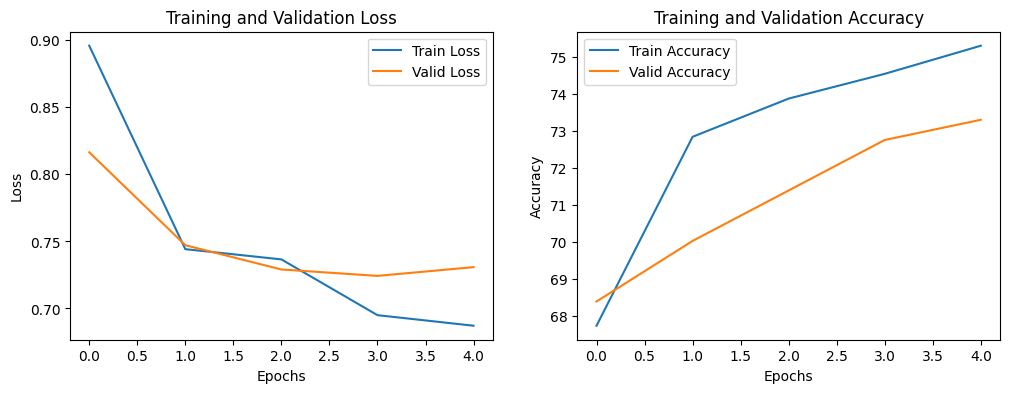

In [60]:
# Plotting training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(valid_accuracies, label='Valid Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()


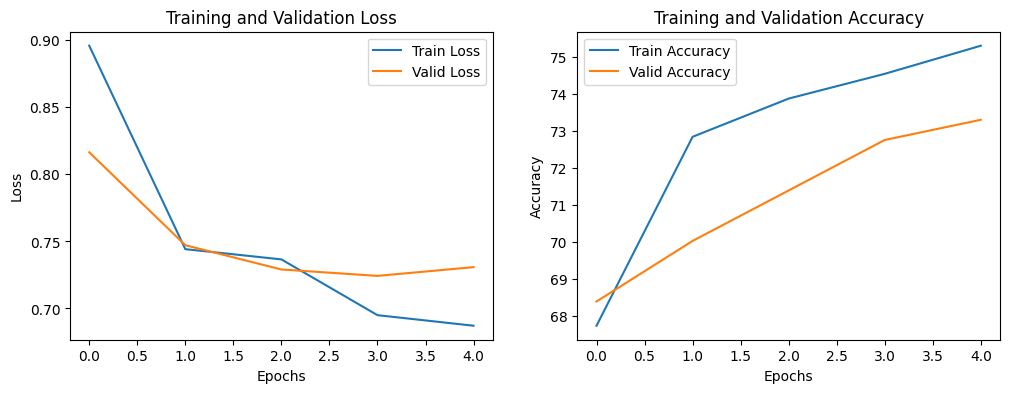

In [61]:
# Plotting training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(valid_accuracies, label='Valid Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()


In [68]:
torch.save(model.state_dict(), 'DR_Simple_CNN_Model_Matthew(Dict).pt')

In [72]:
model =
torch.load('DR_Simple_CNN_Model_Matthew(Dict).pt')

OrderedDict([('conv1.weight',
              tensor([[[[-1.7872e-01, -1.7648e-01, -1.7526e-04],
                        [-7.2637e-02,  2.7426e-02, -1.4873e-01],
                        [ 1.5628e-01,  1.2214e-01,  1.4334e-01]],
              
                       [[-8.6892e-02,  1.4128e-01, -1.8893e-01],
                        [-1.0530e-01, -1.1385e-01,  8.3697e-02],
                        [-1.0715e-01,  1.1795e-01,  9.2770e-02]],
              
                       [[ 1.0748e-01,  1.6086e-01,  1.0865e-01],
                        [-7.6468e-03, -1.1546e-01, -1.2785e-01],
                        [ 9.7328e-02,  1.8923e-01, -1.3365e-01]]],
              
              
                      [[[ 1.5165e-01,  1.4794e-01, -1.1788e-01],
                        [ 1.8921e-01,  1.3913e-01,  1.5389e-01],
                        [ 4.0394e-02, -2.4756e-02, -1.1190e-01]],
              
                       [[-1.3512e-01,  5.3756e-02, -1.3761e-02],
                        [-1.4065e-01,  6.0409

In [76]:
model = SimpleCNN()
model.load_state_dict(torch.load('DR_Simple_CNN_Model_Matthew(Dict).pt'))
model.eval()

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=100352, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=5, bias=True)
  (batch_norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)